This file cotnains preliminary exploratory data analysis of early results for the DBT formulation. Those results have not been included in the thesis and have only been used to direct the research.

In [2]:
from experiment_data import ExperimentData, Database, Query, C
import pandas as pd

runs_folder = "../runs"


def avg_time_success(exps):
    exps = [exp for exp in exps if exp.results["termination_condition"] == "optimal"]
    return sum([exp.results["time"] for exp in exps]) / len(exps)


def success_rate(exps):
    return sum([exp.results["termination_condition"] == "optimal" for exp in exps]) / len(exps)

In [3]:
db = Database.populate_from_folder(runs_folder)

## Success rate and average times for varying $\alpha$ and n


In [4]:
query = Query()
# query.add_filter(C("instance_arguments//n") == 6)
# query.add_filter(C("instance_arguments//alpha") == 0.5)
query.add_filter(C("formulation_arguments//use_better_obj") == True)

data_db = query.apply(db)


In [5]:
# ind = (C("formulation_arguments//use_better_obj"), C("instance_arguments//n"))
ind = (C("instance_arguments//alpha"), C("instance_arguments//n"))
data = data_db.index_on(*ind)

In [6]:
res = []
for k, v in data.items():
    res.append((k, success_rate(v), avg_time_success(v)))

res.sort(key=lambda x: (x[0][3], x[0][1]))

for r in res:
    print(f"Alpha: {r[0][1]}, n: {r[0][3]}, success rate: {r[1]}, avg time: {r[2]}")

Alpha: 0.2, n: 4, success rate: 0.995, avg time: 4.061057435807271
Alpha: 0.5, n: 4, success rate: 0.99, avg time: 4.177588791558237
Alpha: 0.8, n: 4, success rate: 1.0, avg time: 4.249383255243301
Alpha: 0.2, n: 5, success rate: 0.995, avg time: 19.805225185413455
Alpha: 0.5, n: 5, success rate: 0.995, avg time: 25.32938854298999
Alpha: 0.8, n: 5, success rate: 0.975, avg time: 29.176058338849973
Alpha: 0.2, n: 6, success rate: 1.0, avg time: 243.62835726380348
Alpha: 0.5, n: 6, success rate: 0.99, avg time: 272.676902025637
Alpha: 0.8, n: 6, success rate: 0.98, avg time: 377.4603269927356
Alpha: 0.2, n: 7, success rate: 0.885, avg time: 2572.2813913754826
Alpha: 0.5, n: 7, success rate: 0.73, avg time: 2891.152748289174
Alpha: 0.8, n: 7, success rate: 0.175, avg time: 3248.3866050243378


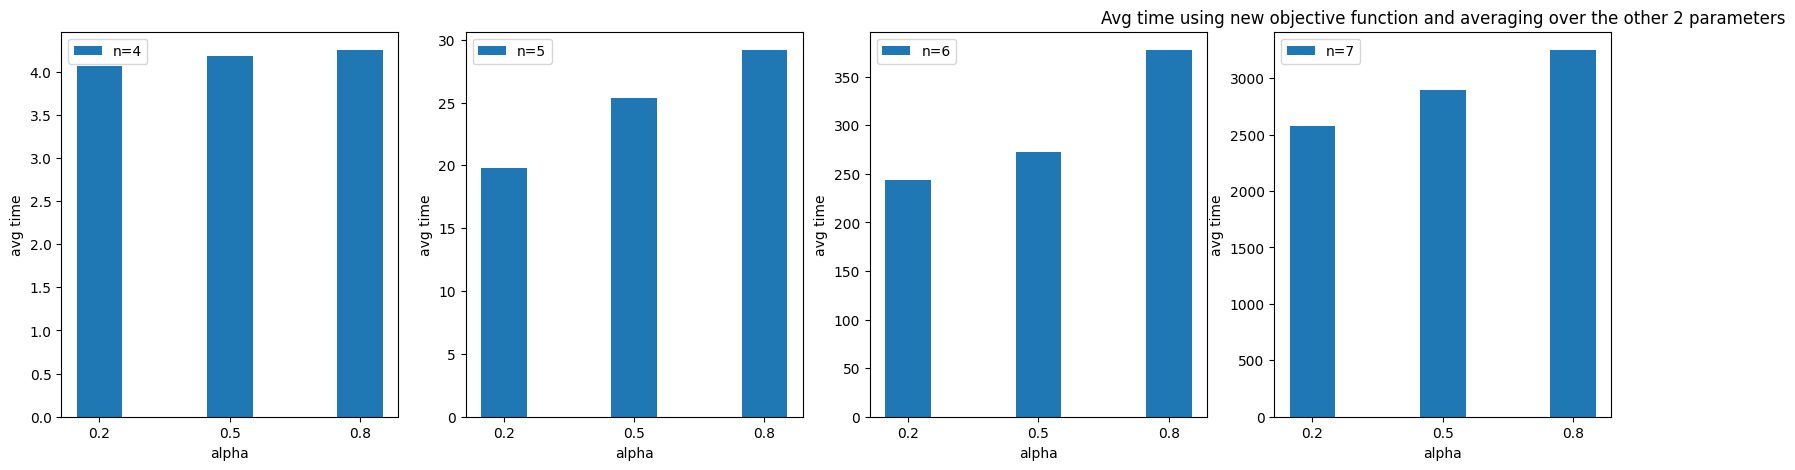

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
width = 0.35

alphas = sorted(set([r[0][1] for r in res]))
ns = sorted(set([r[0][3] for r in res]))

x = range(len(alphas))
for i, n in enumerate(ns):
    avg_time = [r[2] for r in res if r[0][3] == n]
    # ax.bar([xi + i * width for xi in x], avg_time, width, label=f"alpha={alpha}")

    ax[i].bar(x, avg_time, width, label=f"n={n}")
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(alphas)
    ax[i].set_xlabel("alpha")
    ax[i].set_ylabel("avg time")
    ax[i].legend()

plt.title("Avg time using new objective function and averaging over the other 2 parameters")

plt.show()



In [8]:
for n in [5, 6, 7]:
    print(f"------------- n = {n} -------------")
    query = Query().add_filter(C("instance_arguments//n") == n)

    data_db_comp = query.apply(db)

    indices = [(C("formulation_arguments//use_better_obj"),), (C("formulation_arguments//use_bind_first_steiner"),),
               (C("formulation_arguments//use_convex_hull"),)]
    for ind in indices:
        data_index_comp = data_db_comp.index_on(*ind)
        data_index_comp.keys()
        res = []
        for k, v in data_index_comp.items():
            res.append([k, success_rate(v), avg_time_success(v), pd.Series([exp.results["time"] for exp in v]).std()])

        res.sort(key=lambda x: x[2])
        
        for i in range(2):
            print(f"{ind[0].filter_path[1]}: {res[i][0][1]}, success rate: {res[i][1]}, avg time: {res[i][2]}, std: {res[i][3]}")
        print("-------------")

------------- n = 5 -------------
use_better_obj: False, success rate: 0.9983333333333333, avg time: 21.456630317118012, std: 15.095084720621566
use_better_obj: True, success rate: 0.9883333333333333, avg time: 24.740505072559916, std: 73.25558991736938
-------------
use_bind_first_steiner: False, success rate: 0.9916666666666667, avg time: 22.882594189523648, std: 70.39290505226174
use_bind_first_steiner: True, success rate: 0.995, avg time: 23.297315787630065, std: 26.063135153765046
-------------
use_convex_hull: False, success rate: 0.9883333333333333, avg time: 19.046626324999394, std: 72.30944069346354
use_convex_hull: True, success rate: 0.9983333333333333, avg time: 27.09347522079646, std: 20.29352257480309
-------------
------------- n = 6 -------------
use_better_obj: True, success rate: 0.99, avg time: 297.47124940136865, std: 175.13824707668294
use_better_obj: False, success rate: 0.9966666666666667, avg time: 358.4347433657152, std: 192.6027479441637
-------------
use_bind

## OLS for fixed n

In [101]:
import statsmodels.api as sm

n = 6
query = Query().add_filter(C("instance_arguments//n") == n)
query.add_filter(C("results//termination_condition") == "optimal")
data_db_comp = query.apply(db)

X = []
Y = []
for exp in data_db_comp.experiments:
    assert isinstance(exp, ExperimentData)
    x = [exp.formulation_arguments["use_better_obj"], exp.formulation_arguments["use_bind_first_steiner"],
         exp.formulation_arguments["use_convex_hull"]]

    x = [1 if xi else 0 for xi in x]
    X.append(x)

    Y.append(exp.results["time"])

df = pd.DataFrame(X, columns=["use_better_obj", "use_bind_first_steiner", "use_convex_hull"])
df["intercept"] = 1
df["time"] = Y

model = sm.OLS(df["time"], df[["intercept", "use_better_obj", "use_bind_first_steiner", "use_convex_hull"]])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     57.09
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           1.78e-34
Time:                        17:35:18   Log-Likelihood:                -7690.8
No. Observations:                1192   AIC:                         1.539e+04
Df Residuals:                    1188   BIC:                         1.541e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                314

In [92]:
# perform anova statistics on X, Y

from statsmodels.formula.api import ols

df = pd.DataFrame(X, columns=["use_better_obj", "use_bind_first_steiner", "use_convex_hull"])
df["time"] = Y

df["use_better_obj"] = df["use_better_obj"].astype('category')
df["use_bind_first_steiner"] = df["use_bind_first_steiner"].astype('category')
df["use_convex_hull"] = df["use_convex_hull"].astype('category')

formula = "time ~ use_better_obj * use_bind_first_steiner * use_convex_hull"

model = ols(formula, data=df).fit()

anova_results = sm.stats.anova_lm(model, typ=2)  # Use Type II ANOVA
print(anova_results)

                                                          sum_sq      df  \
use_better_obj                                      1.019457e+06     1.0   
use_bind_first_steiner                              6.997160e+04     1.0   
use_convex_hull                                     3.453489e+06     1.0   
use_better_obj:use_bind_first_steiner               3.612458e+03     1.0   
use_better_obj:use_convex_hull                      3.839915e+05     1.0   
use_bind_first_steiner:use_convex_hull              7.582358e+04     1.0   
use_better_obj:use_bind_first_steiner:use_conve...  1.324667e+04     1.0   
Residual                                            3.659363e+07  1192.0   

                                                             F        PR(>F)  
use_better_obj                                       33.207764  1.053518e-08  
use_bind_first_steiner                                2.279253  1.313800e-01  
use_convex_hull                                     112.493849  3.542339e-25  

<Axes: >

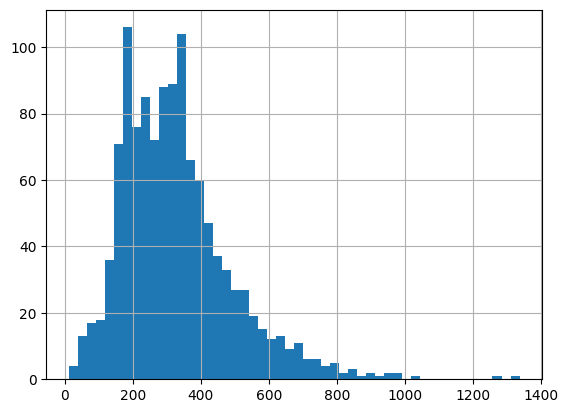

In [105]:
df["time"].hist(bins=50)